In [1]:
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-08-04 13:54:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-08-04 13:54:39 (258 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
    vocab_size = 5000
    embedding_dim = 64
    max_length = 200
    trunc_type = 'post'
    padding_type = 'post'
    oov_tok = "<OOV>"
    training_portion = .8

    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
                 "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did",
                 "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have",
                 "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
                 "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's",
                 "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only",
                 "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd",
                 "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
                 "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
                 "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",
                 "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
                 "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll",
                 "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [4]:
bbc = pd.read_csv("/tmp/bbc-text.csv")
bbc

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [5]:
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
bbc = bbc.sample(frac=1).reset_index(drop=True)

sentence = []
labels = []

for label in bbc.category:
    labels.append(label)

for sen in bbc.text:
    for word in stopwords:
        token = " " + word + " "
        sen = sen.replace(token, " ")
        sen = sen.replace(" ", " ")
    sentence.append(sen)

In [7]:
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(sentence, 
                                                                                          labels, 
                                                                                          train_size=training_portion, 
                                                                                          shuffle=False, 
                                                                                          random_state=None)

train_sentences = np.array(train_sentences)
validation_sentences = np.array(validation_sentences)

train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [8]:
# tokenize the content
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

# tokenize the labels
labels_tokenizer = Tokenizer()
labels_tokenizer.fit_on_texts(labels)

In [9]:
training_labels_seq = np.array(labels_tokenizer.texts_to_sequences(train_labels))
validation_labels_seq = np.array(labels_tokenizer.texts_to_sequences(validation_labels))

In [10]:
model = tf.keras.Sequential([
    # YOUR CODE HERE.
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [12]:
save_model = '/content/sample_data/model.h5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min')

In [13]:
history = model.fit(train_padded,
                    training_labels_seq,
                    epochs=25,
                    validation_data=(validation_padded, validation_labels_seq),
                    callbacks=[earlyStopping, modelCheckpoint, reducelr],
                    verbose=1)

Epoch 1/25
56/56 [==============================] - 6s 38ms/step - loss: 1.5453 - accuracy: 0.3146 - val_loss: 1.1875 - val_accuracy: 0.5416

Epoch 00001: val_accuracy improved from -inf to 0.54157, saving model to /content/sample_data/model.h5
Epoch 2/25
56/56 [==============================] - 1s 23ms/step - loss: 1.1182 - accuracy: 0.5758 - val_loss: 0.9244 - val_accuracy: 0.6337

Epoch 00002: val_accuracy improved from 0.54157 to 0.63371, saving model to /content/sample_data/model.h5
Epoch 3/25
56/56 [==============================] - 1s 23ms/step - loss: 0.5514 - accuracy: 0.8006 - val_loss: 0.4528 - val_accuracy: 0.8112

Epoch 00003: val_accuracy improved from 0.63371 to 0.81124, saving model to /content/sample_data/model.h5
Epoch 4/25
56/56 [==============================] - 1s 23ms/step - loss: 0.4507 - accuracy: 0.8303 - val_loss: 0.2907 - val_accuracy: 0.9034

Epoch 00004: val_accuracy improved from 0.81124 to 0.90337, saving model to /content/sample_data/model.h5
Epoch 5/25


In [14]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Visualization Model Training
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epoch_number = range(len(acc))
    plt.figure(figsize=(6, 6), dpi=100)
    plt.subplot(2,1,1)
    plt.plot(epoch_number, acc, 'r', label='train acc')
    plt.plot(epoch_number, val_acc, 'b', label='val acc')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(epoch_number, loss, 'r', label='train loss')
    plt.plot(epoch_number, val_loss, 'b', label='val loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.show()

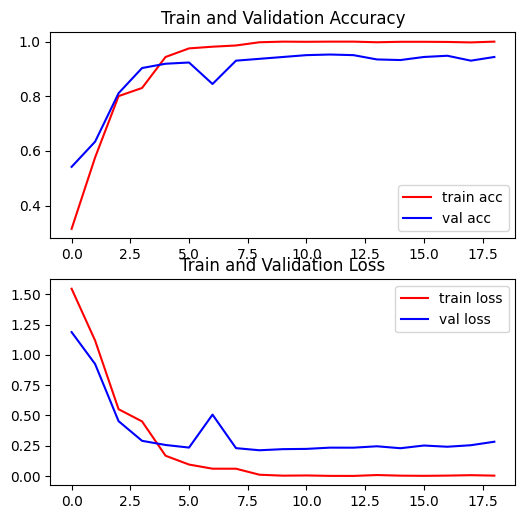

In [15]:
train_visualitation = plot_acc_loss(history)